In [1]:
import os
import glob
import json
from dataclasses import dataclass
import dask.bag
from kerchunk.netCDF3 import NetCDF3ToZarr
from kerchunk.combine import MultiZarrToZarr
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
%matplotlib inline

In [ ]:
atm_files = sorted(glob.glob("/projects/0/nwo2021025/archive/mres_b.e10.B2000_CAM5.f05_t12.001/atm/hist/*.h0.*.nc"))
print(f"{len(atm_files)=}: ({atm_files[0].split('.')[-2]} - {atm_files[-1].split('.')[-2]})")

In [2]:
def open_mfdataset(filepaths: list[str], ncstore_dir: str='~/kerchunk', **kwargs):
    """a faster alternative to xr.open_mfdataset using kerchunk
    
    This function uses kerchunk to create an NC_STORE reference file,
    that instructs the program how to read the netCDF files efficiently. 
    Coordinates must be consistent throughout all files.
    The NC_STORE is saved after first use, and will be read on each 
    subsequent usage of this function.
    
    Parameters:
    filepaths : str or list[str]
        (list of) netCDF file names, may contain wild cards
    ncstore_dir: Pathlike
        Path where NC_STORE reference files will be saved
    kwargs: dict
        any additional keyword arguments are passed on to xr.open_dataset
        
    Returns: xr.Dataset
        a Dataset instance containing all the netCDF data
        
    v0.0
    """
    
    # make sorted list of absolute filepaths
    if isinstance(filepaths, str):
        filepaths = glob.glob(filepaths)
    filepaths = sorted([os.path.abspath(fp) for fp in filepaths])
    if len(filepaths) == 1: # use xr.open_dataset directly if there is one file
        return xr.open_dataset(filepaths, **kwargs)
    
    # set default keyword arguments for xr.open_dataset on NC_STORE file
    default_kw = {'engine':'kerchunk', 'storage_options':{'target_protocol':'file'}}
    for (k,v) in default_kw.items():
        if k in kwargs:
            print(f'open_mfdataset(): ignoring keyword {k}')
        kwargs[k] = v
    
    # create NC_STORE filename from netCDF filename, including timestamp
    # of first and last file. Open and return dataset if the file already exists
    ncstore_dir = os.path.expanduser(ncstore_dir)
    timestr = lambda i: os.path.basename(filepaths[i]).split('.')[-2] # timestamp
    ncstorefile = (os.path.basename(filepaths[0])
                   .replace(timestr(0),f"{timestr(0)}_{timestr(-1)}")
                   .replace('.nc','.json'))
    ncstore_path = os.path.join(ncstore_dir, ncstorefile)
    if not os.path.exists(ncstore_dir):
        os.mkdir(ncstore_dir)
    elif os.path.exists(ncstore_path):
        print(f"Reading combined kerchunk reference file {ncstore_path}")
        return xr.open_dataset(ncstore_path, **kwargs)
    
    # make new NC_STORE data
    filebag = dask.bag.from_sequence(filepaths, npartitions=None)
    reffiles = (filebag.map(NetCDF3ToZarr, inline_threshold=0, max_chunk_size=0)
                .map(lambda z: z.translate()).compute())
    mzz = MultiZarrToZarr(reffiles, concat_dims=['time'], coo_map={'time':'cf:time'})
    
    # write NC_STORE data and return opened dataset
    with open(f"{ncstore_path}", "wb") as f:
       print(f"Writing combined kerchunk reference file {ncstore_path}")
       f.write(json.dumps(mzz.translate()).encode())
    
    return xr.open_dataset(ncstore_path, **kwargs)


def wmean(arr, w, *args, **kwargs):
    """Wrapper for DataArray.weighted.mean to restore coordinate attributes"""
    wmean = arr.weighted(w).mean(*args, **kwargs)
    return wmean.assign_coords({k:arr[k] for k in wmean.coords})


def T0_T1_T2(ds):
    """Calculate T0, T1, T2 and return as dict"""
    sinlat = np.sin(np.deg2rad(ds.lat))
    dims = ('lat','lon')
    T0data = wmean(ds.TREFHT, ds.gw, dims).coarsen(time=12).mean().compute()
    T1data = wmean(ds.TREFHT*sinlat, ds.gw, dims).coarsen(time=12).mean().compute()
    T2data = wmean(ds.TREFHT*(3*sinlat**2-1), ds.gw, dims).coarsen(time=12).mean().compute()
    return {'T0':T0data, 'T1':T1data, 'T2':T2data}

In [4]:
ds = xr.open_dataset("../../data/forcingfiles_from_GLENS/ozone_WACCM_L70_zmMonthly_b.e15.B5505C5WCCML45BGCR.f09_g16.feedback.EM1-20_c20200311.nc")
ds = ds.isel(time=slice(1,-1)) # select 2020 - 2100

In [ ]:
LR-CESM1WAC-CONTRL (2010—2098): /home/jasperdj/nwo2021025/jasper/GLENS1/TREFHT/EM
LR-CESM1WAC-SAI2020 (2020—2100): /home/jasperdj/nwo2021025/jasper/GLENS1/TREFHT/EM
LR-CESM1CAM-CONTRL(0001—0301): /projects/0/nwo2021025/cesm1_0_4/outputdata/spinup_pd_maxcores_f09_g16/output/cam/hist/
LR-CESM1CAM-SAI2020 (2000–2077): /projects/0/nwo2021025/archive/lres_b.e10.B2000_CAM5.f09_g16.feedforward.001/atm/hist/
LR-CESM1CAM-SAI2050 (2000–2099): /projects/0/nwo2021025/archive/lres_b.e10.B2000_CAM5.f09_g16.feedforward_2050.001/atm/hist/
MR-CESM1CAM-CONTRL(0180—0301): /projects/0/nwo2021025/cesm1_0_4/outputdata/spinup_pd_maxcores_f05_t12/output/atm/hist/
MR-CESM1CAM-SAI2050 (2045—2099): /projects/0/nwo2021025/archive/mres_b.e10.B2000_CAM5.f05_t12.001/atm/hist/

#### Other locations #####
MR-CESM1CAM-CONTRL(2000—2101): /projects/0/prace_imau/prace_2013081679/cesm1_0_4/f05_t12/rcp8.5_co2_f05_t12/atm/hist/yearly/
MR-CESM1CAM-CONTRL(0200—0301): /projects/0/prace_imau/prace_2013081679/cesm1_0_4/f09_g16/spinup_pd_maxcores_f09_g16/OUTPUT/ocn/hist/monthly/

In [ ]:
ds = {
    'CAM-Control':,
    'CAM-SAI 2020':,
    'WACCM-Control':,
    'WACCM-SAI 2020':
}

In [5]:
cam_cnt = 
cam_sai =
waccm_cnt =
waccm_sai = T0_T1_T2(ds)

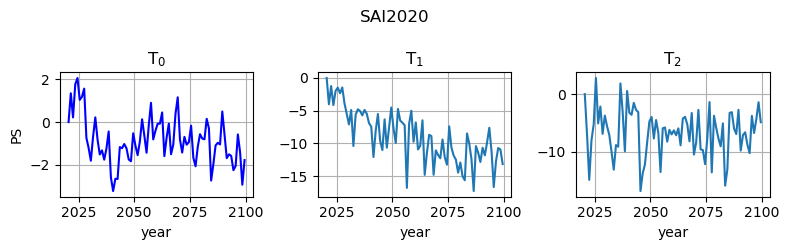

In [8]:
cols = ['firebrick', 'navy', 'orangered', 'dodgerblue']
labels = ['CAM-Control', 'CAM-SAI 2020', 'WACCM-Control', 'WACCM-SAI 2020']
data = [cam_cnt, cam_sai, waccm_cnt, waccm_sai]

fig, ax = plt.subplots(1,3, figsize=(8,2.5), sharex=True)
(waccm_sai['T0']-waccm_sai['T0'][0]).plot(ax=ax[0], c='b')
(waccm_sai['T1']-waccm_sai['T1'][0]).plot(ax=ax[1])
(waccm_sai['T2']-waccm_sai['T2'][0]).plot(ax=ax[2])
ax[0].set_title(r'T$_0$')
ax[1].set_title(r'T$_1$')
ax[2].set_title(r'T$_2$')
for axi in ax:
    axi.grid()
    axi.set_xlabel('year')
fig.suptitle('SAI2020')
plt.tight_layout()